In [1]:
import pickle
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Read PCA parameters

In [55]:

D=pickle.load(open('data/PCA.pickle','rb'))
col=D['columns']
eigvec=D['eigvec']
eigval=D['eigval']

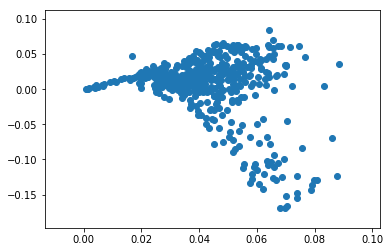

In [59]:
scatter(eigvec[:,0],eigvec[:,1])

## compute features

In [60]:
features=eigvec[:,:20]
features.shape

(481, 20)

##  compute labels (sectors)

In [61]:
TickerInfo=pd.read_csv('data/TickerInfo.tsv',sep='\t')
print(TickerInfo.shape)
TickerInfo.head()

(505, 5)


,Unnamed: 0,Ticker,Name,Sector,SECTOR_ID
0,0,MMM,3M|3M Company,Industrials,INDS
1,1,ABT,Abbott Laboratories,Health Care,HC
2,2,ABBV,AbbVie Inc.,Health Care,HC
3,3,ACN,Accenture plc,Information Technology,IT
4,4,ATVI,Activision Blizzard,Information Technology,IT


In [62]:
Sectors={'Consumer Discretionary':'CD',
 'Consumer Staples':'CS',
 'Energy':'EN',
 'Financials':'FIN',
 'Health Care':'HC',
 'Industrials':'INDS',
 'Information Technology':'IT',
 'Materials':'MAT',
 'Real Estate':'RE',
 'Telecommunication Services':'TS',
 'Utilities':'UTIL'}
sector2number={}
i=0;
for name,short in Sectors.items():
    sector2number[short]=i
    i+=1
sector2number

{'CD': 0,
 'CS': 1,
 'EN': 2,
 'FIN': 3,
 'HC': 4,
 'INDS': 5,
 'IT': 6,
 'MAT': 7,
 'RE': 8,
 'TS': 9,
 'UTIL': 10}

In [66]:
labels=[]
feature_vectors=[]
for i in range(len(col)):
    c=col[i]
    if 'train' in c:
        ticker=c[6:-2]
        answer=list(TickerInfo[TickerInfo.Ticker==ticker]['SECTOR_ID'])
        if len(answer)==1:
            sector_no=sector2number[answer[0]]
            labels.append(sector_no)
            feature_vectors.append(features[i,:])
        else:
            print('error: could not find sector for ticker:',ticker)


In [68]:
len(labels),len(feature_vectors)

(392, 392)

In [73]:
y=np.array(labels)
X=np.array(feature_vectors) #.transpose()
X.shape, y.shape

((392, 20), (392,))

In [74]:
#this is a case where cross validation can help.

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30)
X_train.shape, X_valid.shape

((274, 20), (118, 20))

In [77]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

In [78]:
dtrain.num_col(),dtrain.num_row(),dvalid.num_col(),dvalid.num_row()

(20, 274, 20, 118)

In [87]:
param={}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.3      # shrinkage parameter
param['silent'] = 0     # not silent
param['objective'] = 'multi:softmax'
param['nthread'] = 7 # Number of threads used
param['num_class']=11
#param['eval_metric'] = ''
num_round=100
plst = param.items()
print(param)
evallist = [(dtrain, 'train'), (dtest, 'eval')]

{'max_depth': 3, 'eta': 0.3, 'silent': 0, 'objective': 'multi:softmax', 'nthread': 7, 'num_class': 11}


In [80]:
bst1000 = xgb.train(plst, dtrain, num_round, evallist, verbose_eval=False)

In [81]:
y_pred_1000 = bst1000.predict(dtest, ntree_limit=bst1000.best_ntree_limit, output_margin=True)
y_test = dtest.get_label()

In [82]:
len(y_pred_1000)

118

In [32]:
len(y_test)

118

In [86]:
#[np.argmax(pred) for pred in y_pred_1000]
y_pred_1000[:2]

array([[ 1.7682081 ,  0.7406807 ,  1.2261474 , -0.93267024, -0.96036917,
         1.4524696 ,  1.9840795 ,  0.26607475,  1.0682966 , -0.9892    ,
        -0.9833054 ],
       [ 1.7682081 ,  0.7406807 ,  1.2261474 , -0.93267024, -0.96036917,
         1.4524696 ,  1.9840795 ,  0.26607475,  1.0682966 , -0.9892    ,
        -0.9833054 ]], dtype=float32)